# 第七章 仓位优化

## 7.1 导言

在本章中，我们将利用股票的收益率预测和股票风险模型，实现股票组合权重的配置。

对于收益率预测模型和风险模型，我们将使用前文所述模型。
在这两部分中，基础的理论框架是完善的，也得到了业界的公认。
所以，处理方法大同小异。我们也展示了通用的方法。

而对于如何配置股票组合权重，学界虽有成熟的框架，
但无奈实践中却往往因为股票相关性过高，以致无法使用。
解决股票相关性过高的方法倒是有很多，但总还是莫衷一是。
到底什么方法最优，还是缺乏共识。

所以，我们在这里，选择一些常用的方法，一方面为读者展示业界在遇到困难时，解决问题的思路；一方面抛砖引玉，以期引发读者思考，找出更好的解决方案。

## 7.2 基础知识准备

那么首先，我们介绍一下学界的此问题的处理框架：
$$U = w^T R - \frac{\lambda}{2} w^T \Sigma w$$
其中，U是效用，w是各标的投资权重的列向量，
R是各标的预测收益率的列向量，$\Sigma$是标的间的协方差矩阵。

欲使效用最大化，则效用函数对权重的一阶导数应当等于0：
$$R - \lambda \Sigma w = 0$$
这样就算出了权重：
$$w = \frac{1}{\lambda} \Sigma^{-1} R$$
于是，理论上很完美的解决了问题。

关于$\lambda$，它是风险厌恶系数。在利用美股数据的实证研究中，我们了解到，美国投资者的风险厌恶系数在2-4之间。不过，我们并不严格选择一个风险厌恶系数，而通常用它来调节权重w的尺度。

实践中，R的估计往往不够准确，并没有什么办法来使之更准确，所以，我们更多的努力将放在：即使R不够准确，怎样使w受到的影响最小。
而更为糟糕的是，协方差矩阵$\Sigma$还往往不可逆。这带来的问题非常严重。究其原因，还是资产之间相关性太高。这个问题并不能通过算法来完全解决，但更好的算法总有帮助。在本章的最后一节中，我们也会介绍一些从其他角度解决问题的方案。总之，本章内容是建立在一个偏科学的框架下的一个偏工程的优化问题。

## 7.3 操作总览

本实验由以下几个步骤组成：
1. 步骤一：收益率预测因子的组合
2. 步骤二：计算理论上最优的股票仓位
3. 步骤三：调整理论上最优的股票仓位

## 7.4 操作流程

### 7.4.0 准备工作

和前面的章节一样，本章的代码也是可以独立运行的，所以我们需要先做一些准备工作。在本节中，我们将进行完整的量化投资研究流程，所以，前面几章的内容，几乎都在我们的准备工作中。因此，本节的准备工作稍长。

#### 7.4.0.1 数据准备

首先我们导入包：

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import acf
from statsmodels import api

import tushare as ts

然后我们获取股票数据和上证50指数数据：

In [2]:
stock_list = ts.get_sz50s().code
stock_data = {}
for stock in stock_list:
    stock_data[stock] = ts.get_k_data(stock, start='2017-01-01', end='2017-12-31')
    
stock_fundemental = ts.get_stock_basics()
    
index_name = '000016'
index_data = ts.get_k_data(index_name, index=True, start='2017-01-01', end='2017-12-31')

C:\Users\huang\Anaconda3\lib\site-packages\tushare\stock\classifying.py:266: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  ct.PAGES['sz50b']), parse_cols=[0, 4, 5])


整理数据：

In [3]:
#整理股票数据
stock_0 = pd.DataFrame(index=index_data.date)
stock_na = pd.DataFrame(index=index_data.date)
stock_open = stock_0.copy()
stock_high = stock_0.copy()
stock_low = stock_0.copy()
stock_close = stock_0.copy()

for stock in stock_list:
    stock_0 = stock_0.join(pd.DataFrame(0.0, index=stock_data[stock].date, columns=[stock]))
    stock_na = stock_na.join(pd.DataFrame(stock_data[stock].open.isna().values, index=stock_data[stock].date, columns=[stock]))
    stock_open = stock_open.join(pd.DataFrame(stock_data[stock].open.values, index=stock_data[stock].date, columns=[stock]))
    stock_high = stock_high.join(pd.DataFrame(stock_data[stock].high.values, index=stock_data[stock].date, columns=[stock]))
    stock_low = stock_low.join(pd.DataFrame(stock_data[stock].low.values, index=stock_data[stock].date, columns=[stock]))
    stock_close = stock_close.join(pd.DataFrame(stock_data[stock].close.values, index=stock_data[stock].date, columns=[stock]))
    
stock_rtn = stock_0.copy()
for stock in stock_list:
    stock_rtn[stock] = stock_close[stock] / stock_close[stock].shift() - 1
stock_rtn = stock_rtn.fillna(0)

#整理指数数据
index_0 = pd.DataFrame(0.0, index=index_data.date, columns=[index_name])
index_open = pd.DataFrame(index_data.open.values, index=index_data.date, columns=[index_name])
index_high = pd.DataFrame(index_data.high.values, index=index_data.date, columns=[index_name])
index_low = pd.DataFrame(index_data.low.values, index=index_data.date, columns=[index_name])
index_close = pd.DataFrame(index_data.close.values, index=index_data.date, columns=[index_name])

index_rtn = index_close / index_close.shift() - 1
index_rtn = index_rtn.fillna(0)

#计算主动收益率
stock_active_rtn = stock_rtn - np.repeat(index_rtn.values, stock_rtn.columns.size, axis=1)
stock_active_rtn_std = stock_active_rtn.std()

#### 7.4.0.2 收益率预测模型准备

构造收益率预测模型：

In [4]:
#计算红三兵
def cal_rtn_predictor_r3s():
    #初始化返回值
    res = stock_0.copy().fillna(0)
    #计算每只股票的预测值
    for stock in stock_list:
        #计算每日的预测值
        for i in range(2, len(stock_0)):
            idx = list(range(i - 2, i + 1))      
            if stock_na[stock][idx].sum():
                #剔除近三日有停牌的股票
                res[stock][i] = 0.0
            else:
                o = stock_open[stock][idx].copy()
                c = stock_close[stock][idx].copy()
                h = stock_high[stock][idx].copy()
                l = stock_low[stock][idx].copy()
                r = stock_rtn[stock][idx].copy()
                os = o.shift(-1)
                #计算
                d = (r > 0).sum()
                #近三日中有两日以上上涨
                if d > 0:
                    #每日开盘是否在上日K线实体之内
                    in_entity = (os > o).sum() + (os < c).sum()
                    #计算惩罚函数
                    loss = (c / h - 1).std() + r.std() + (3 - d) / 100 + (4 - in_entity) / 100
                    if loss < 0.05:
                        #看涨，预测收益率
                        res[stock][i] = 0.05 - loss
                #近三日中有两日以上没有上涨
                elif d < 0:
                    #每日开盘是否在上日K线实体之内
                    in_entity = (os < o).sum() + (os > c).sum()
                    #计算惩罚函数
                    loss = (c / l - 1).std() + r.std() + (3 - d) / 100 + (4 - in_entity) / 100
                    if loss < 0.05:
                        #看跌，预测收益率
                        res[stock][i] = -0.05 + loss
    return res

#计算动量因子
def cal_rtn_predictor_ma():
    
    #计算均线
    def ma_calculator(data, n):
        res = data.copy()
        for i in range(1, n):
            res += data.shift(i)
        return res / n
    
    #计算动量因子
    stock_ma_excess = ma_calculator(stock_close, 3) / ma_calculator(stock_close, 13) - 1
    stock_ma_excess_quantile = stock_ma_excess.fillna(0.0).rank(axis=1) / (stock_list.size + 1)
    return stock_ma_excess_quantile.apply(stats.norm(0,1).ppf)

构造精炼收益预测的函数：

In [18]:
def cal_alpha(rtn_predictor, method):
    
    #计算自相关系数
    def cal_acf(rtn_predictor):
        acf_all = pd.Series(index=stock_list)
        for stock in stock_list:
            acf_all[stock] = acf(rtn_predictor[stock])[1]
        return acf_all.mean()

    #计算IC
    def cal_ic(rtn_predictor, n = 1):
        res = pd.Series((n), dtype=float)
        for i in range(n):
            res[i] = np.corrcoef(stock_active_rtn.shift(-i - 1).fillna(0.0).values.reshape(stock_active_rtn.size), rtn_predictor.values.reshape(rtn_predictor.size))[0,1]
        return res

    #计算衰减系数
    def cal_ac(rtn_predictor):
        ic = cal_ic(rtn_predictor, 60)
        ac = ic / ic.shift()
        return ac.mean()

    #计算时间尺度上的混合信号
    def cal_mix_predictor(rtn_predictor, af, ac):
        res = rtn_predictor.copy()
        for i in range(1, len(res)):
            res.iloc[i, :] = rtn_predictor.iloc[i, :] - af * rtn_predictor.iloc[i - 1, :] + ac * res.iloc[i - 1, :]
        return res
    
    #计算时间序列信号的精炼预测
    def cal_ts_alpha(rtn_predictor, ic):
        z = rtn_predictor / rtn_predictor.values.std()
        return np.repeat(np.array(stock_active_rtn_std).reshape(1, stock_rtn.columns.size), len(stock_rtn), axis=0) * ic * z
    
    #计算截面信号的精炼预测
    def cal_cs_alpha(rtn_predictor, ic):
        std_cs = rtn_predictor.std(axis = 1)
        z = rtn_predictor.fillna(0.0) / np.repeat(std_cs.values.reshape(std_cs.size, 1), stock_list.size, axis=1)
        z_omega = z / np.repeat(stock_active_rtn_std.values.reshape(1, stock_active_rtn_std.size), len(stock_active_rtn), axis=0)
        c = z_omega.fillna(1.0).values.std()
        return ic / c * z.fillna(0.0)

    
    #开始计算
    af = cal_acf(rtn_predictor)
    ic = cal_ic(rtn_predictor)[0]
    ac = cal_ac(rtn_predictor)
    rtn_mix_predictor = cal_mix_predictor(rtn_predictor, af, ac)
    
    if method == 'ts':
        #时间序列信号
        return cal_ts_alpha(rtn_mix_predictor, ic)
    elif method == 'cs':
        #截面信号
        return cal_cs_alpha(rtn_mix_predictor, ic)
    else:
        print('wrong method!')
        return rtn_predictor

计算收益率模型，获取精炼预测：

In [20]:
rtn_predictor_r3s = cal_rtn_predictor_r3s()
rtn_predictor_ma = cal_rtn_predictor_ma()

alpha_r3s = cal_alpha(rtn_predictor_r3s, 'ts')
alpha_ma = cal_alpha(rtn_predictor_ma, 'cs')

#### 7.4.0.3 风险预测模型准备

我们先构造风险因子：

In [25]:
#构造市场因子
def cal_beta_market():
    
    #计算beta
    def cal_beta():
        
        #计算单股票的单日的beta
        def cal_beta_1s1d(stock, n):
            if n < 3:
                return 1.0
            elif n < 20:
                return stats.linregress(index_rtn[index_name][0:n - 1], stock_rtn[stock][0:n - 1]).slope
            else:
                return stats.linregress(index_rtn[index_name][n - 20:n - 1], stock_rtn[stock][n - 20:n - 1]).slope        

        
        #开始计算beta
        res = stock_0.copy()
        for stock in stock_list:
            for i in range(len(index_rtn)):
                res[stock][i] = cal_beta_1s1d(stock, i)
        return res
    
    
    #开始计算市场因子
    beta = cal_beta()
    beta_mean = np.repeat(beta.mean(axis=1).values.reshape(len(beta), 1), stock_list.size, axis=1)
    beta_std = np.repeat(beta.std(axis=1).values.reshape(len(beta),1), stock_list.size, axis=1)
    return (beta - beta_mean) / beta_std


#构造规模因子
def cal_beta_assets():
    stock_assets = stock_fundemental.totalAssets[stock_list]
    beta_assets = np.log(stock_assets)
    return (beta_assets - beta_assets.mean()) / beta_assets.std()


#构造成长因子
def cal_beta_value():
    stock_value = stock_fundemental.pe[stock_list]
    beta_value = np.log(np.log(stock_value))
    return (beta_value - beta_value.mean()) / beta_value.std()


#计算因子收益率
def cal_factor_rtn(beta_market, beta_assets, beta_value):
    res = stock_0.iloc[:,0:3].copy()
    res.columns = ['market', 'assets', 'values']
    for i in range(3, len(res)):
        Y = stock_rtn.iloc[i].values.copy()
        X = np.asarray([beta_market.iloc[i], beta_assets, beta_value]).T 
        res.iloc[i] = api.OLS(Y, X).fit().params
    return res

接下来，我们计算风险因子，并算出因子收益率，从而算出因子的协方差矩阵和股票的协方差矩阵：

In [27]:
beta_market = cal_beta_market()
beta_assets = cal_beta_assets()
beta_value = cal_beta_value()
beta_all = pd.DataFrame([beta_market.iloc[-1], beta_assets, beta_value], index=['market','assets', 'value'])
factor_rtn = cal_factor_rtn(beta_market, beta_assets, beta_value)
factor_rtn_cov = factor_rtn.cov()
stock_rtn_cov = np.dot(np.dot(beta_all.T, factor_rtn.cov()), beta_all)

有了以上准备工作，我们终于可以开始进入正题了：

### 7.4.1 步骤一：收益率预测因子的组合

现在，我们需要把这两个预测因子融合成一个预测。
对于这类问题，基本的思路就是线性组合。
那么，问题转化为，如何求得一个权重，
使得两个预测因子的线性组合达到“最优”。

这个问题，定义不同意义上的“最优”自然会催生不同的算法。
我们选择其中一种相对简单的做法：
我们认为，两个因子的预测能力，应当是相差无几的。这点从两个因子的IC可以看出来，都在0.02左右。
此时，对于组合预测因子来说，与其考虑获得更高的收益风险比，
不如考虑更为重要东西——分散因子本身可能失效的风险。
基于这种理念，经过数学推导，最优的权重应当如下：
$$w = V^{-1}e$$
其中，w是各因子的权重，V是因子间相关系数，$e = (1, 1)^T$。

然后，再将w标准化即可。

那么，我们先来算算因子的协方差矩阵。我们先来计算最后一天的情形：

[[3.06226954e-08 4.41770558e-09]
 [4.41770558e-09 6.83134894e-08]]


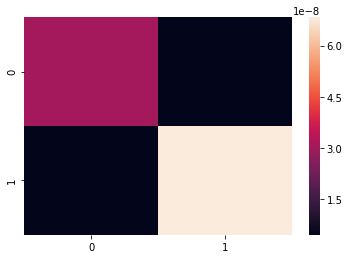

In [32]:
alpha_cov = np.cov(alpha_r3s.iloc[-1], alpha_ma.iloc[-1])
print(alpha_cov)
sns.heatmap(alpha_cov)
plt.show()

我们同样画出热力图，很明显，这个协方差矩阵是对角占优的，那么后面求逆时，应该问题不大。
我们接下来，计算次日两因子应具有的权重：

In [50]:
def cal_factor_weight_1d(cov):
    l = cov.shape[0]
    e = np.mat(np.repeat([1], l)).T
    w = np.mat(cov).I * e
    return w / w.sum()

print(cal_factor_weight_1d(alpha_cov))

[[0.7091591]
 [0.2908409]]


接下来，我们计算每日两因子应具有的权重：

In [65]:
factor_weight = pd.DataFrame(0.5, index=index_0.index, columns=['r3s', 'ma'])
for i in range(12,len(factor_weight)):
    cov = np.cov(alpha_r3s.iloc[i], alpha_ma.iloc[i])
    factor_weight.iloc[i] = cal_factor_weight_1d(cov).T
print(factor_weight.tail())

                 r3s        ma
date                          
2017-12-25  0.408355  0.591645
2017-12-26  0.771349  0.228651
2017-12-27  0.360159  0.639841
2017-12-28  0.585091  0.414909
2017-12-29  0.709159  0.290841


我们可以画一个权重随时间的变化图来看看：

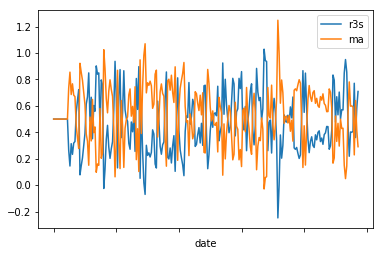

In [66]:
factor_weight.plot()
plt.show()

可以看出，大部分时候，权重都挺合理的。有个别时候出现权重大于一或小于零的情形。

接下来，我们把每天的因子权重乘到因子的精炼预测上，就可以得到每天对收益率的最终预测：

In [77]:
alpha_all = stock_0
for i in range(len(alpha_all)):
    alpha_all.iloc[i] = alpha_r3s.iloc[i] * factor_weight.r3s[i] + alpha_ma.iloc[i] * factor_weight.ma[i]
print(alpha_all.tail())

              600000    600016    600019    600028    600029    600030  \
date                                                                     
2017-12-25 -0.000152 -0.000110  0.000106  0.000218  0.000455  0.000129   
2017-12-26 -0.000052 -0.000038  0.000171  0.000394  0.000055  0.000037   
2017-12-27 -0.000026  0.000054  0.000121  0.000255  0.000162  0.000066   
2017-12-28  0.000011  0.000041  0.000428  0.000363  0.000074  0.000126   
2017-12-29  0.000048 -0.000005  0.000161  0.000058  0.000129  0.000004   

              600036    600048    600050    600104    ...       601688  \
date                                                  ...                
2017-12-25  0.000034  0.000571 -0.000104  0.000264    ...    -0.000070   
2017-12-26 -0.000024  0.000214 -0.000037 -0.000094    ...    -0.000036   
2017-12-27  0.000049  0.000337 -0.000084 -0.000107    ...    -0.000085   
2017-12-28 -0.000076  0.000174 -0.000046 -0.000077    ...    -0.000050   
2017-12-29 -0.000104  0.000076 -0.000

我们选几只股票来画图看看，我们的最终预测是如何变化的：

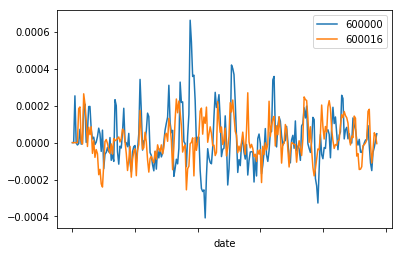

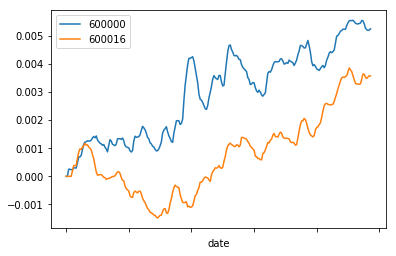

In [83]:
alpha_all.iloc[:,0:2].plot()
plt.show()
alpha_all.iloc[:,0:2].cumsum().plot()
plt.show()

这样，我们就完成了对收益率预测因子的组合。

### 7.4.2 步骤二：计算理论上最优的股票仓位

现在，我们知道了股票的预测收益率和股票间的协方差矩阵， 我们几乎就能立刻算出股票的最优投资权重了：
$$w = \frac{1}{\lambda} \Sigma^{-1} R$$

In [144]:
stock_weight = pd.DataFrame(1.0 / 50, index=index_0.index, columns=stock_list)
for i in range(len(stock_weight)):
    w = np.mat(alpha_all.iloc[i].values) * np.mat(stock_rtn_cov).I
    stock_weight.iloc[i] = w / w.sum()
print(stock_weight.tail())

code          600000    600016    600019    600028    600029    600030  \
date                                                                     
2017-12-25  0.062172 -0.142055  0.080114 -0.032418  0.008313  0.170856   
2017-12-26  0.032229 -0.213252  0.053120  0.075737  0.085191  0.092056   
2017-12-27  0.095534 -0.196493  0.072825  0.081257  0.085316  0.119761   
2017-12-28  0.151175 -0.446056  0.119019  0.041071  0.104240  0.229033   
2017-12-29 -0.276367  0.174267 -0.098671  0.276590  0.125328 -0.164360   

code          600036    600048    600050    600104    ...       601688  \
date                                                  ...                
2017-12-25 -0.037042 -0.279001  0.224233  0.140451    ...    -0.174868   
2017-12-26 -0.083751 -0.819678  0.208274  0.208986    ...    -0.149824   
2017-12-27 -0.085362 -0.816507  0.199039  0.316770    ...    -0.153112   
2017-12-28 -0.100089 -0.618337  0.243245  0.396810    ...    -0.189803   
2017-12-29  0.012535 -0.231857 -0.187

C:\Users\huang\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


我们选几只股票来看看它们的仓位是如何变动的：

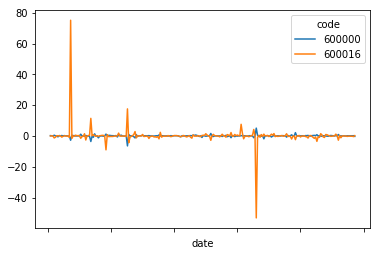

In [106]:
stock_weight.iloc[:,0:2].plot()
plt.show()

可以看出，仓位还是很不稳定，竟然出现融资50倍的情形。归根结底还是协方差矩阵的可逆性的问题。
我们画出最后一日各股票的仓位图看看：

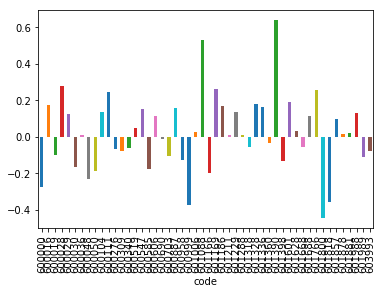

In [107]:
stock_weight.iloc[-1].plot(kind='bar')
plt.show()

负的非常多，可见，理论上最优的股票仓位，还是很有问题的。

### 7.4.3 步骤三：调整理论上最优的股票仓位

那么接下来，我们对上述算法进行改进。

首先，我们来看看，如果R全都相等，是否有这个问题。这意味着，我们将采用和预测因子的组合相同的方法来处理股票组合。

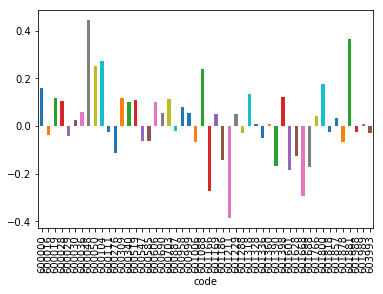

In [143]:
stock_weight_e = pd.DataFrame(1.0 / stock_list.size, index=index_0.index, columns=stock_list)
for i in range(len(stock_weight)):
    w = np.mat(np.repeat([1], stock_list.size)) * np.mat(stock_rtn_cov).I
    stock_weight_e.iloc[i] = w / w.sum()
stock_weight_e.iloc[-1].plot(kind='bar')
plt.show()

从图上看，问题有所好转，但也尚未根治。于是我们采取更有道理一点的做法：我们观察$\alpha$，把大于一定值的预测全部令为该值，否则记为0。这样，我们大大减小了收益预测的自由度，而且，也利用了其所包含的信息。我们先来看看$\alpha$的分布：

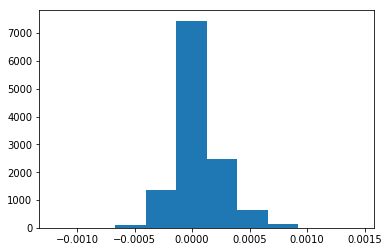

In [113]:
plt.hist(alpha_all.values.reshape(alpha_all.values.size, 1))
plt.show()

从图上看，我们大致可以0.0001为界：小于-0.0001的，就令为-0.0001，大于0.0001的，就令为0.0001，中间的记为0：

In [161]:
alpha_all_01 = (alpha_all >= 0.0001) * 0.0001 + (alpha_all <= -0.0001) * -0.0001
alpha_all_01 = alpha_all_01[alpha_all_01 != False].fillna(0.0)
print(alpha_all_01.tail())

            600000  600016  600019  600028  600029  600030  600036  600048  \
date                                                                         
2017-12-25 -0.0001 -0.0001  0.0001  0.0001  0.0001  0.0001  0.0000  0.0001   
2017-12-26  0.0000  0.0000  0.0001  0.0001  0.0000  0.0000  0.0000  0.0001   
2017-12-27  0.0000  0.0000  0.0001  0.0001  0.0001  0.0000  0.0000  0.0001   
2017-12-28  0.0000  0.0000  0.0001  0.0001  0.0000  0.0001  0.0000  0.0001   
2017-12-29  0.0000  0.0000  0.0001  0.0000  0.0001  0.0000 -0.0001  0.0000   

            600050  600104   ...    601688  601766  601800  601818  601857  \
date                         ...                                             
2017-12-25 -0.0001  0.0001   ...       0.0  0.0000     0.0 -0.0001  0.0001   
2017-12-26  0.0000  0.0000   ...       0.0  0.0000     0.0  0.0000  0.0001   
2017-12-27  0.0000 -0.0001   ...       0.0  0.0001     0.0  0.0001  0.0001   
2017-12-28  0.0000  0.0000   ...       0.0  0.0000     0.0  0.0

再来算算权重：

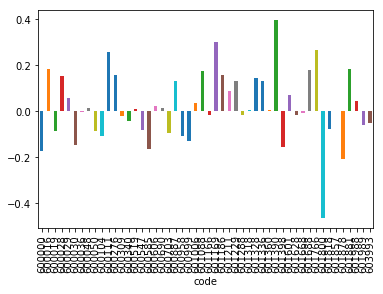

In [162]:
stock_weight_01 = pd.DataFrame(1.0 / stock_list.size, index=index_0.index, columns=stock_list)
for i in range(len(stock_weight_01)):
    w = np.mat(alpha_all_01.iloc[i].values) * np.mat(stock_rtn_cov).I
    if w.sum() != 0:
        stock_weight_01.iloc[i] = w / w.sum()
    else:
        pass
stock_weight_01.iloc[-1].plot(kind='bar')
plt.show()

看起来还是有一定缓解的，不过，还是没能解决问题。无奈之下，我们只有使用流氓手段了，我们可以强行把仓位拉到1/50附近，这样，就很难在有负的持仓了。

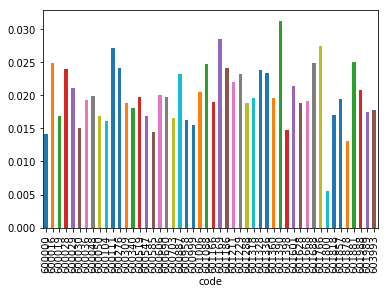

In [164]:
stock_weight_stable = stock_weight_01 * 0.03 + pd.DataFrame(1.0 / stock_list.size, index=index_0.index, columns=stock_list) * 0.97
stock_weight_stable.iloc[-1].plot(kind='bar')
plt.show()

上面的参数0.03和0.97纯属试出来的结果，并没有什么别的意义。但无论如何，我们总算得到了看起来还不错的股票仓位，也算解决了问题。
以上，我们就算从头到尾体验了量化投资的研究全过程。到这一步为止，我们已经得出了股票的仓位，可以直接用于交易了。
值得提醒的是，千万不要认为量化交易一定是程序化交易。
目前我国监管部门对股票市场的程序化交易时比较谨慎的，但对量化交易是持开放态度的。
我们完全可以用量化的方式得出股票的仓位，然后手工交易。这并不违背量化交易的本质。

同样，很多程序化交易其实就是简单规则的实现，反而算不上量化交易。在这一点上，希望读者能够辨明。

## 7.5 延伸阅读

### 7.5.1 Black-Litterman 模型

前面我们实验中遇到的问题，即协方差矩阵的可逆性问题，多年前的量化投资研究员就遇到过。
在那时，为了解决这个问题，诞生了一个名为“Black-Litterman”模型的工具。
尽管，这个模型目前已经不流行了，但笔者认为了解它的思路仍然是有启发的，故在这里简单介绍一下。

它是由Fisher Black和Robert Litterman在1992年首先提出的，是基于金融行业对Markowitz模型数十年的研究和应用的基础上优化而来。
它的重点在于，我们先从股票的协方差矩阵和市场持仓（即市值）计算出市场对股票的一致预期收益。
然后把我们计算的$\alpha$和这个一直预期收益加权平均。当然，权重肯定是我们的预测较低，一般在2%到3%之间。
这是一种非常明显的贝叶斯统计的思路，把先验信息和新信息结合在一起了。
然后，再用后验的预期收益率和协方差矩阵的逆，得出我们的仓位。
这里还是用到了协方差矩阵的逆，那么为什么对可逆性问题的解决有帮助呢？

因为，如果正着不能求出逆，那么，我们可以用数值方法去优化，而在本模型中，由于我们的预测的权重远低于市场一致预期收益的权重，
这意味着，我们有一个很好的初值点——市场持仓。利用市场持仓作为初值点，运用数值方法去搜索最优持仓，往往能比较好的解决问题。

### 7.5.2 处理海量资产时的另一种思路

前面提到的协方差矩阵的可逆性问题，归根结底是股票相关性较高的问题，也是因为我们有海量的股票造成的。
那么，如果我们的股票相关性较低呢？有没有办法使我们的股票相关性较低？

这催生了另一种思路，我们不要去预测股票，我们去预测一些股票组合。这些股票组合之间相关性可以做到较低。
我们推荐的《主动投资组合管理》的作者，格林纳德所在的基金，就采用了这种思路。

我们可以在做风险模型时，找出每个风险因子的因子组合——这个组合在该因子上暴露为1，而在其它因子上的暴露的平方和最小。
这个是可以做到的，并没有什么难度。然后，我们在做股票收益率预测模型时，不要预测股票收益率，而去预测风险因子的因子收益率。
这个理解起来可能有点混乱，我们需要去找一些收益预测因子，用它们去预测风险因子的因子收益率。然后，风险因子有自己的因子组合和协方差矩阵。
由于风险因子在设计时就考虑了底相关性的问题，所以，这里的协方差矩阵几乎一定可逆。这样，我们通过降维的方式，解决了这个问题。

这种方法目前并不主流，大概是因为我们的预测因子有很多是截面因子，而截面因子是预测股票收益率的，
而不能直接用于预测因子收益率，这会带了一些麻烦。不过，无论如何，这也是一种很好的思路。

### 7.5.3 讨论：大类资产配置与股票组合权重配置的异同

在一个大型的基金中，大类资产配置非常重要，
他们的职位通常比基金经理高，
也往往需要更为敏锐的洞察力。
在这一领域，数学模型往往帮不上太多的忙，
只能在数据处理和可视化上，提供些许帮助。

导致这一问题的原因有二：
1. 大类资产之间，相关性较弱。
2. 大类资产的收益预测，更多依赖于对宏观政治经济的理解。

前者，我们前面对股票配置建模时，一个核心要素就是股票的协方差矩阵。
可是，大类资产间的相关系数矩阵接近单位矩阵。
这就导致了我们用同样的方法做配置，并没有什么用。

后者，一个有名的例子就是索罗斯，
他所开创的宏观对冲交易流派，
非常强调对各国的政治经济的非凡理解。
这样，数学模型可以施展的空间就更小了。

不过，这虽然很难，倒也无妨，
毕竟世界并不需要那么多智者来做大类资产配置。
在股票间做配置已经可以给我们提供足够的工作岗位了。

### 7.5.4 主流的策略评估指标及其优劣

一般的民众，对投资的认识，就仅止于收益。
而我们专业人员，则应考虑风险。
一份风险一份收益，我们更多会考虑我每承担一份风险，会获得多大收益？

通常，我们给投资人介绍策略时，都会给出一些评估指标，
这些指标大部分也就是各种收益、风险、收益/风险。

比如收益类：一个月收益、三个月收益、半年收益、一年收益、三年收益……

再如风险类：年化波动率、最大回撤、最大回撤时间、β……

再如收益/风险类：夏普比率、信息比率、特雷诺比率、詹森比率、收益回撤比……

评估指标是丰富多彩，而且现在也有很多第三方机构，
以非常专业的手段对策略进行评估，他们的评估指标更加全面而细致，
能让投资者更加全面的评估一家基金的能力。

但如果没有充分的持仓数据，仅凭一条收益曲线，如何评价一个策略好不好呢？
首先，看曲线走势：
1. 如果和股指走势相关性高，则证明主体策略为指数增强。
2. 如果收益率有明显的右偏分布的特性，则证明是CTA。
3. 如果收益稳定但较低，且有左偏分布的特性，则证明是债券。
4. 如果收益稳定但较低，并没有左偏右偏的特性，则证明是α策略。
4. 如果收益高风险低，则证明是高频/套利策略。
5. 有了初步看法后，再重点分析该曲线各典型时段的收益，看和同行中哪些比较接近。

有了策略类型的观点后，再套用合适的策略评估指标，
和同策略的基金比较，看看谁更厉害。

另外，一般投资者比较关注最大回撤和收益回撤比。
所以，我们的客服人员也应该关注这两个指标。
但是，我们专业做投资的，却不应该关注这两个指标，
因为，既然是最最最大回撤，那描述的应该是小概率事件，
拿一个小概率事件的特性来说明整个策略的收益分布，
实在是没有道理的。

事实上，根据中心极限定理，当我们的投资充分分散后，
我们的收益分布应该服从渐进正态分布，
那么我们关心的，仅仅一个标准差和夏普比率，就足够了。